In [1]:
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from nerf_xray.deformation_fields import BSplineField3d, BSplineField1d, BsplineTemporalDeformationField3d
from tqdm import tqdm, trange

In [2]:
old_ng = 8
timestamp = '2024-08-12_100310'
folder = Path('/teamspace/studios/this_studio/neural_xray/outputs/kel_E/nerf_def_xray/'+
    timestamp +
    '/nerfstudio_models')
p = list(folder.glob('*.ckpt'))
assert len(p)==1
p = p[0]
p

PosixPath('/teamspace/studios/this_studio/neural_xray/outputs/kel_E/nerf_def_xray/2024-08-12_100310/nerfstudio_models/step-000004000.ckpt')

In [3]:
data = torch.load(Path(p))
_data = {}
key_map = {}
for key in data['pipeline'].keys():
    if 'deformation' in key:
        _data[key.split('deformation_field.')[1]] = data['pipeline'][key]
        key_map[key.split('deformation_field.')[1]] = key
data = _data

deformation_field = BsplineTemporalDeformationField3d(
    support_range=[(-1,1),(-1,1),(-0.7,0.7)], num_control_points=(old_ng, old_ng, old_ng), 
    support_outside=True, weight_nn_width=16
)
deformation_field.load_state_dict(data)

<All keys matched successfully>

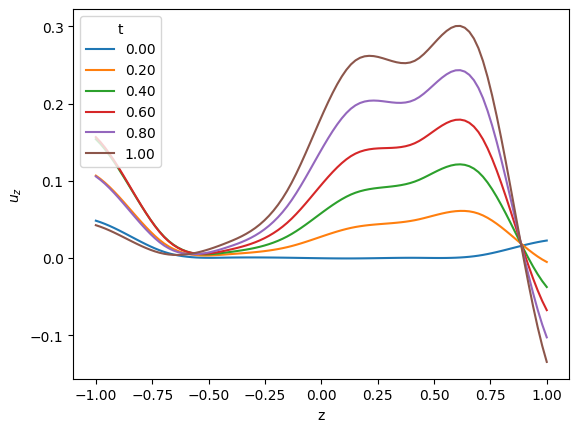

In [4]:
with torch.no_grad():
    for t in np.linspace(0,1,6):
        z = torch.linspace(-1, 1, 100)
        pos = torch.stack([0.0*torch.ones_like(z), 0.0*torch.ones_like(z), z], dim=1)
        time = torch.ones_like(z)*t
        u = deformation_field(pos, time) - pos
        plt.plot(z, u[:,2], label=f'{t:.2f}')
plt.legend(title='t')
plt.xlabel('z')
plt.ylabel('$u_z$')
plt.show()

10


100%|██████████| 1000/1000 [00:17<00:00, 57.09it/s, loss=1.58e-5, lr=0.0001] 


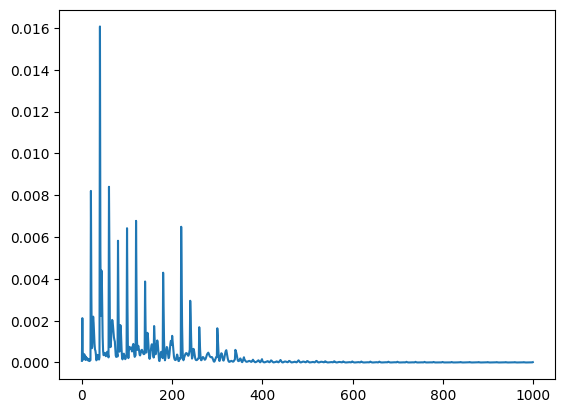

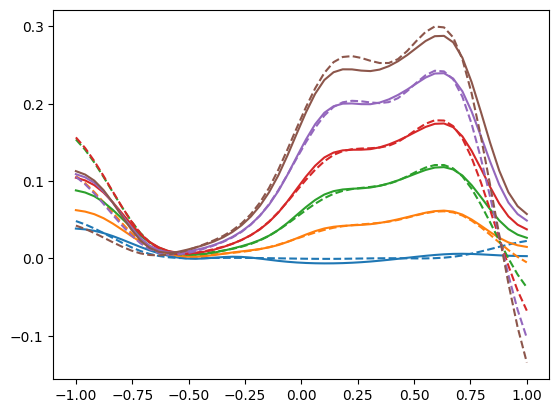

In [5]:
# create a second field and try to match the deformation
ng = old_ng + 2
print(ng)
df2 = BsplineTemporalDeformationField3d(
    support_range=[(-1,1),(-1,1),(-0.7,0.7)], 
    num_control_points=(ng,ng,ng), 
    support_outside=True, 
    weight_nn_width=16
)
# gradient descent
optimizer = torch.optim.AdamW(df2.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 1.0, 0.01, 1000)
losses = []
pbar = trange(1000)

for i in pbar:
    optimizer.zero_grad()
    nq = ng+1
    x = torch.linspace(-1, 1, nq)
    y = torch.linspace(-1, 1, nq)
    z = torch.linspace(-0.7, 0.7, nq)
    X,Y,Z = torch.meshgrid(x,y,z, indexing='ij')
    pos = torch.stack([X.reshape(-1), Y.reshape(-1), Z.reshape(-1)], dim=1)
    _t = (i%20)/20
    t = _t*torch.ones_like(pos[:,0])
    uA = deformation_field(pos, t)
    uB = df2(pos, t)
    loss = torch.nn.functional.mse_loss(uA, uB)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())
    phi1 = deformation_field.weight_nn(torch.tensor(_t).reshape(-1,1))
    phi2 = df2.weight_nn(torch.tensor(_t).reshape(-1,1))
    pbar.set_postfix({'loss':loss.item(), 'lr':scheduler.get_last_lr()[0]})
plt.plot(losses, label='loss')
plt.show()

with torch.no_grad():
    for i,t in enumerate(np.linspace(0,1,6)):
        z = torch.linspace(-1, 1, 50)
        pos = torch.stack([torch.zeros_like(z), torch.zeros_like(z), z], dim=1)
        time = torch.ones_like(z)*t
        u = deformation_field(pos, time) - pos
        plt.plot(z, u[:,2], label=f'{t:.2f}', ls='--', color=f'C{i}')
        u = df2(pos, time) - pos
        plt.plot(z, u[:,2], label=f'{t:.2f}', color=f'C{i}')
# plt.legend()
plt.show()

In [6]:
data = torch.load(p)
new_dict = df2.state_dict()
for key in key_map:
    data['pipeline'][key_map[key]] = new_dict[key].to('cuda')
new_p = p.with_name(p.stem+'-mod.ckpt')
torch.save(data, new_p)
print(new_p)

/teamspace/studios/this_studio/neural_xray/outputs/kel_E/nerf_def_xray/2024-08-12_100310/nerfstudio_models/step-000004000-mod.ckpt


In [6]:
p = Path('/teamspace/studios/this_studio/neural_xray/outputs/kel_E/nerf_xray/2024-08-11_204442/nerfstudio_models/step-000001000.ckpt')
assert p.exists()
data = torch.load(p)
data['pipeline'].pop('_model.camera_optimizer.pose_adjustment')
torch.save(data, p.with_name('step-000001000-mod.ckpt'))
data.keys()

dict_keys(['step', 'pipeline', 'optimizers', 'schedulers', 'scalers'])

In [47]:
for key in data['pipeline'].keys():
    if 'optimizer' in key:
        print(key)

_model.camera_optimizer.pose_adjustment
